# A. BASIC TEXT CLASSIFICATION USING NAIVE BAYES AND BAG-OF-WORDS

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load Dataset
data = pd.read_csv('/kaggle/input/newsarticlecategories/news-article-categories.csv')  # Assume CSV has two columns: 'headline' and 'category'

# Step 2: Split Dataset into Features (X) and Target (y)
X = data['category']  # Features (news headlines)
y = data['title']  # Labels (news categories)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Text Preprocessing - Bag-of-Words (BoW)
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_train_bow = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_bow = vectorizer.transform(X_test)  # Transform test data (use the same vocabulary as train data)

# Step 5: Build and Train Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

# Step 6: Predict on Test Data
y_pred = nb_model.predict(X_test_bow)

# Step 7: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")
# i have commented the below line code....because the result is big....remove the comment(#) and run
print(classification_report(y_test, y_pred))

Accuracy: 0.36%
Classification Report:
                                                                                                                                                                                       precision    recall  f1-score   support

                                                                                                "Finding New Horizons for Korea in its Past: The Cultural Pioneering of Jin Yong Lee"       0.00      0.00      0.00         1
                                                                                                                                        "Throwing Out the Clock" on Teacher Education       0.00      0.00      0.00         1
                                                                                                          #MeToo Creator Will Push Button To Drop New Year's Eve Ball In Times Square       0.00      0.00      0.00         1
                                                                    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

# B. NEWS ARTICLE CATEGORIZATION USING BERT

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset with 'category', 'title', and 'body' columns
df = pd.read_csv('/kaggle/input/newsarticlecategories/news-article-categories.csv')

# Convert categories to numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# Ensure the 'body' column contains strings (in case of NaNs or other issues)
df['body'] = df['body'].astype(str)

# Split the dataset into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['body'], df['category'], test_size=0.2, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
max_length = 128  # Maximum token length
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=max_length)

# Convert labels to tensors
train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

# Convert encodings to tensors
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_masks = torch.tensor(val_encodings['attention_mask'])

# Create PyTorch dataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# Create DataLoader for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category'].unique()))
model = model.to('cuda')  # If using a GPU

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_masks, labels = [b.to('cuda') for b in batch]
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')

# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_masks, labels = [b.to('cuda') for b in batch]
        
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, predictions)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(true_labels, predictions, target_names=le.classes_))

# Sample input and prediction
sample_text = "Researchers have discovered a new species of butterfly in the Amazon rainforest."
encoded_sample = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
encoded_sample = {key: value.to('cuda') for key, value in encoded_sample.items()}

# Predict category
model.eval()
with torch.no_grad():
    output = model(**encoded_sample)
    predicted_class = torch.argmax(output.logits, dim=1).item()

predicted_category = le.inverse_transform([predicted_class])
print(f'Predicted Category: {predicted_category[0]}')


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 1.808250232318113
Epoch 2, Loss: 0.8619529542534851
Epoch 3, Loss: 0.5432523071419361
Validation Accuracy: 0.7885174418604651
                precision    recall  f1-score   support

ARTS & CULTURE       0.89      0.84      0.86       206
      BUSINESS       0.71      0.77      0.74       116
        COMEDY       0.80      0.84      0.82        73
         CRIME       0.67      0.81      0.73        54
     EDUCATION       0.86      0.78      0.82       101
 ENTERTAINMENT       0.76      0.81      0.78        99
   ENVIRONMENT       0.88      0.83      0.85       110
         MEDIA       0.78      0.73      0.75        63
      POLITICS       0.75      0.74      0.74       102
      RELIGION       0.77      0.85      0.81        93
       SCIENCE       0.70      0.86      0.78        58
        SPORTS       0.93      0.90      0.91       100
          TECH       0.74      0.64      0.69        95
         WOMEN       0.65      0.63      0.64       106

      accuracy   

# C. SPAM DETECTION IN EMAIL USING LSTM NETWORKS

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8305 - loss: 0.4657 - val_accuracy: 0.8592 - val_loss: 0.4120
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8683 - loss: 0.3969 - val_accuracy: 0.8592 - val_loss: 0.4073
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8686 - loss: 0.3980 - val_accuracy: 0.8592 - val_loss: 0.4083
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8749 - loss: 0.3846 - val_accuracy: 0.8592 - val_loss: 0.4083
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8701 - loss: 0.3900 - val_accuracy: 0.8592 - val_loss: 0.4067
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Accuracy: 85.92%
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       958
           1       0.00      0.00      0.00       157

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.74      0.86      0.79    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


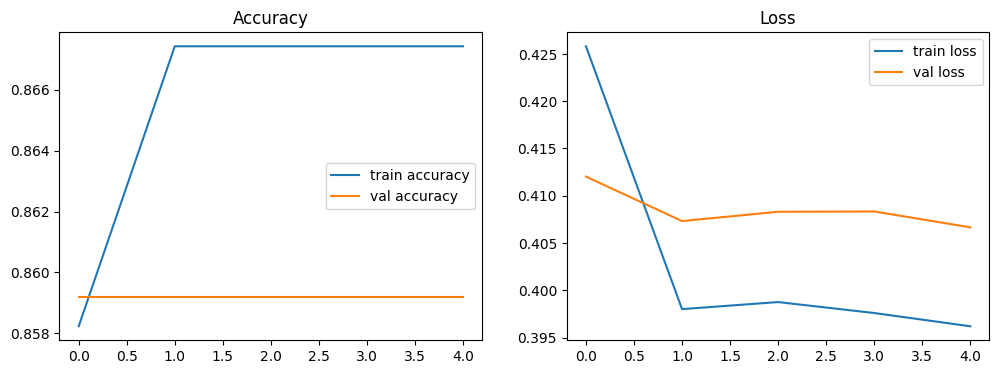

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
# Assuming dataset is in CSV format with columns 'category' and 'message'
data = pd.read_csv('/kaggle/input/spam-email-classification/email.csv')
data.columns = ['category', 'message']

# Encode labels: spam=1, ham=0
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Preprocessing
X = data['message']
y = data['category']

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform input size
max_len = 100
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
